In [1]:
import os, glob
import xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np
import pandas as pd
import wrf
from netCDF4 import Dataset

In [22]:
fs = 14
plt.rc("font", size=fs)

In [3]:
simName = "SH"

In [4]:
start = pd.to_datetime("2015-03-28 12:30")
end   = pd.to_datetime("2015-03-29 00:00")
dates = pd.date_range(start=start,end=end,freq='30min')

In [5]:
figPath = "/glade/u/home/doubrawa/figs"

In [6]:
bao_lat = 40.050028
bao_lon = -105.003835

# One single panel

/glade/u/home/doubrawa/figs/SH_2015-03-28_08_30_00_LT_k=7.png


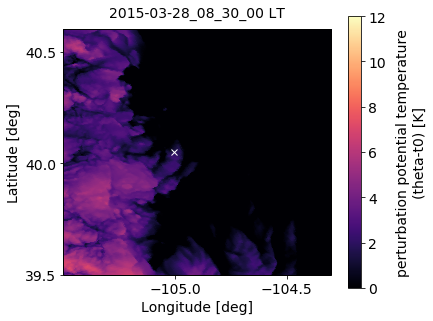

In [24]:
k    = 7
vmin = 0
vmax = 12
dv   = 1
varName = 'T'

for date in dates[4:]:

    simPath    = "/glade/scratch/doubrawa/{0}/032815/wrfout_d03_{1:%Y-%m-%d_%H:%M:%S}".format(simName,date)    
    ncfile     = Dataset(simPath)
    var        = wrf.getvar(ncfile, varName)
    lats, lons = wrf.latlon_coords(var)
    cart_proj  = wrf.get_cartopy(var)    

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(1,1,1,projection=cart_proj)
    p1 = ax.pcolormesh(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(var)[1,:,:], cmap='magma',vmin=vmin,vmax=vmax)

    ax.plot(bao_lon,bao_lat,'x',lw=2,mec='w',mfc='None')
    
    ax.set_xlim([-105.5,-104.3])
    ax.set_xticks([-105,-104.5])
    ax.set_xlabel('Longitude [deg]')

    ax.set_ylim([39.5,40.6])
    ax.set_yticks([39.5,40.0,40.5])
    ax.set_ylabel('Latitude [deg]')    
    
    cbar = plt.colorbar(p1)
    
    varTitle = var.description
    if len(varTitle) > 30:
        part1 = ' '.join(var.description.split(' ')[0:-1])
        part2 = var.description.split(' ')[-1]
        varTitle = part1+'\n'+part2
        
    cbar.set_label('{0} [{1}]'.format(varTitle,var.units), labelpad=10)

    vertical_coord = [ x for x in var.dims if 'bottom' in x ]
    vertical_coord = vertical_coord[0]
    
    date = pd.Timestamp(date).tz_localize('UTC').tz_convert('US/Mountain')
    dateStr = "{0:%Y-%m-%d_%H_%M_%S}".format(date)
    
    ax.set_title(dateStr+" LT",y=1.025,fontsize=fs)
    
    figName = "{0}_{1}_LT_k={2}.png".format(simName,dateStr,k)
    figName = os.path.join(figPath,figName)
    print figName
    
#     fig.subplots_adjust(bottom=0.15,top=0.85)
#     fig.savefig(figName,dpi=300,bbox_to_inches="tight")
    break

In [18]:
    date = pd.Timestamp(date).tz_localize('UTC').tz_convert('US/Mountain')
    print "{0:%Y-%m-%d_%H_%M_%S}".format(date)

2015-03-28_08_30_00


# Plot instantaneous fields

/glade/u/home/doubrawa/figs/MYNN_CP_vs_NoCP_2015-03-28_16_30_00_k=10.png


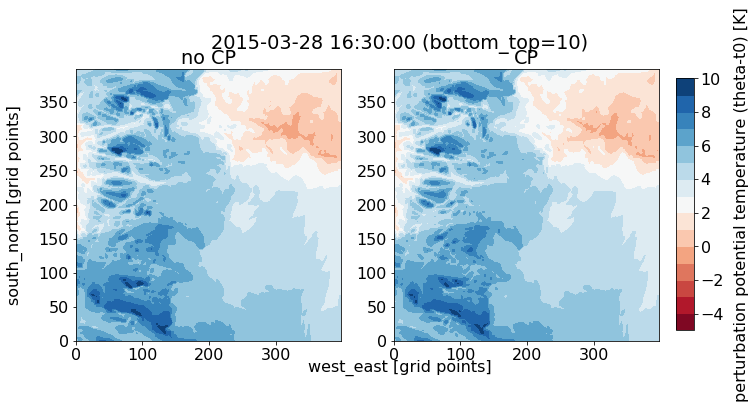

In [36]:
k    = 10
vmin = 295-300
vmax = 310-300
dv   = 1
varName = 'T'

for date in dates:

    simPath   = "/glade/scratch/doubrawa/{0}/032815/wrfout_d03_{1:%Y-%m-%d_%H:%M:%S}".format(simName,date)
    simPathCP = "/glade/scratch/doubrawa/{0}/032815-CP/wrfout_d03_{1:%Y-%m-%d_%H:%M:%S}".format(simName,date)
    data = xarray.open_dataset(simPath) 
    dataCP = xarray.open_dataset(simPathCP)     
    
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(1,2,1)
    p1 = ax1.contourf(data[varName].data[0,k,:,:],cmap='RdBu',levels=np.arange(vmin,vmax+1e-2,dv))
    ax1.set_title("no CP")

    ax2 = fig.add_subplot(1,2,2)
    p2 = ax2.contourf(dataCP[varName].data[0,k,:,:],cmap='RdBu',levels=np.arange(vmin,vmax+1e-2,dv))
    ax2.set_title("CP")

    ax1.set_ylabel('south_north [grid points]', labelpad=15)
    fig.text(0.5, 0.05, 'west_east [grid points]', ha='center', va='center')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.155, 0.02, 0.7])
    cbar = plt.colorbar(p2, cax=cbar_ax)
    cbar.set_label('{0} [{1}]'.format(data[varName].description,data[varName].units), labelpad=10)

    vertical_coord = [ x for x in data[varName].dims if 'bottom' in x ]
    vertical_coord = vertical_coord[0]
    fig.suptitle("{0} ({1}={2})".format(pd.to_datetime(data[varName].XTIME.data[0]),vertical_coord,k),y=0.98)
    
    dateStr = "{0:%Y-%m-%d_%H_%M_%S}".format(date)
    figName = "{0}_CP_vs_NoCP_{1}_k={2}.png".format(simName,dateStr,k)
    figName = os.path.join(figPath,figName)
    print figName
    
#     fig.subplots_adjust(bottom=0.15,top=0.85)
#     fig.savefig(figName,dpi=300,bbox_to_inches="tight")
    break

# Plot mean fields

In [15]:
firstTime = 1

for date in dates:

    simPath   = "/glade/scratch/doubrawa/{0}/032815/wrfout_d03_{1:%Y-%m-%d_%H:%M:%S}".format(simName,date)
    simPathCP = "/glade/scratch/doubrawa/{0}/032815-CP/wrfout_d03_{1:%Y-%m-%d_%H:%M:%S}".format(simName,date)
    data = xarray.open_dataset(simPath) 
    dataCP = xarray.open_dataset(simPathCP)        
    
    if firstTime:
        var = data[varName]
        varCP = dataCP[varName]
        firstTime = 0
    else:
        var = xarray.concat([var,data[varName]],dim='Time')
        varCP = xarray.concat([varCP,dataCP[varName]],dim='Time')        

In [25]:
k = 10

/glade/u/home/doubrawa/figs/MYNN_CP_vs_NoCP_TemporalMean_k=10.png


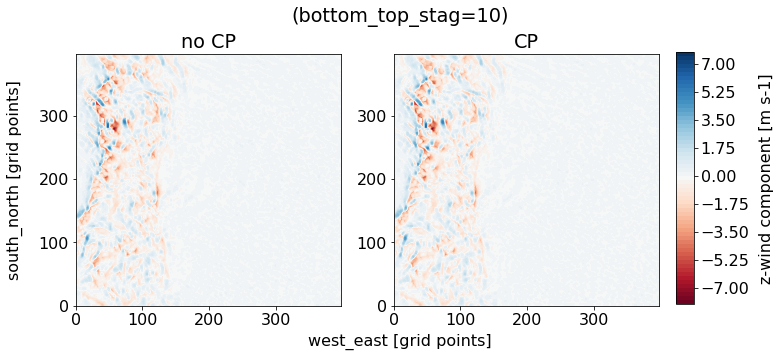

In [26]:
nocp = var.mean('Time').data[k,:,:]
cp = varCP.mean('Time').data[k,:,:]

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
p1 = ax1.contourf(nocp,cmap='RdBu',levels=np.arange(vmin,vmax,dv))
ax1.set_title("no CP")

ax2 = fig.add_subplot(1,2,2)
p2 = ax2.contourf(cp,cmap='RdBu',levels=np.arange(vmin,vmax,dv))
ax2.set_title("CP")

ax1.set_ylabel('south_north [grid points]', labelpad=15)
fig.text(0.5, 0.05, 'west_east [grid points]', ha='center', va='center')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.155, 0.02, 0.7])
cbar = plt.colorbar(p2, cax=cbar_ax)
cbar.set_label('{1} [{2}]'.format(simName,data[varName].description,data[varName].units), labelpad=10)

vertical_coord = [ x for x in data[varName].dims if 'bottom' in x ]
vertical_coord = vertical_coord[0]
fig.suptitle("({1}={2})".format(pd.to_datetime(data[varName].XTIME.data[0]),vertical_coord,k),y=0.98)

figName = "{0}_CP_vs_NoCP_TemporalMean_k={1}.png".format(simName,k)
figName = os.path.join(figPath,figName)
print figName
fig.subplots_adjust(bottom=0.15,top=0.85)
fig.savefig(figName,dpi=300)